In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [2]:
path_root='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'

#case,machine_target='OM4p5_CORE2_IAF_COBALT_abio_csf_mle200','gfdl.ncrc4-intel16-prod'
#case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-013120','gfdl.ncrc4-intel16-prod'

case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-060821','gfdl.ncrc4-intel16-prod'


In [3]:
short_casename=case.replace('OM4p5_CORE2_IAF_','')
short_casename

'gzCOBALT-060821'

In [4]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz']
#zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [5]:
tmpdir = '/work/Jessica.Luo/tmp/'+case
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821


In [6]:
# read in files
diagTypes = ['ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)

['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.01.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.02.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.03.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.04.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.05.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.06.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.07.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.08.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.09.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-060821/ocean_cobalt_tracers_int.1988-2007.10.nc', '/work/Jessica.Luo/

In [7]:
grid_file=tmpdir+'/ocean_static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

## Biomass evaluation

In [8]:
import pandas as pd
dt2=pd.read_csv('dt2cast.csv')
dt2

,lon,lat,chl_gs_mean,Appendicularians,Thaliaceans,Copepods,Tunicates
0,-179.5,-59.5,0.390548,NaN,NaN,NaN,NaN
1,-179.5,-58.5,0.327493,NaN,NaN,NaN,NaN
2,-179.5,-57.5,0.284213,NaN,NaN,NaN,NaN
3,-179.5,-56.5,0.280899,NaN,NaN,NaN,NaN
4,-179.5,-55.5,0.263312,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
32780,179.5,58.5,1.285610,NaN,NaN,10.051831,NaN
32781,179.5,59.5,1.756678,NaN,NaN,5.944884,NaN
32782,179.5,60.5,1.761255,NaN,NaN,1.014612,NaN
32783,179.5,61.5,2.025337,NaN,NaN,3.915913,NaN


In [9]:
APP_CORR = 10 # REMSEN ET AL. 2004 (tables 4-5) suggest it should range from 5-15x for tunicates
THAL_CORR = 10

dt2.Appendicularians_adj = dt2.Appendicularians * APP_CORR
dt2.Thaliaceans_adj = dt2.Thaliaceans * THAL_CORR

In [10]:
val=(ds.mesozoo_200 * cobalt_n_2_c * carbon_molar_mass * 1000).mean().values
print('mean tunicate biomass (top 200 m) - non area weighted: ' + str(np.round(val,2)) + ' mg C m-2')

mean tunicate biomass (top 200 m) - non area weighted: 903.32 mg C m-2


In [11]:
val=((ds.nsmt_100 + ds.nlgt_100) * cobalt_n_2_c * carbon_molar_mass * 1000).mean().values
print('mean tunicate biomass (top 100 m): ' + str(np.round(val,2)) + ' mg C m-2')

mean tunicate biomass (top 100 m): 186.29 mg C m-2


In [12]:
val=(((ds.nsmt_100.mean(dim='time')*grid.areacello).sum()/grid.areacello.sum()) * cobalt_n_2_c * carbon_molar_mass * 1000).mean().values
print('mean small tunicate biomass (top 100 m) - area weighted: ' + str(np.round(val,2)) + ' mg C m-2')

mean small tunicate biomass (top 100 m) - area weighted: 34.31 mg C m-2


In [13]:
val=(((ds.nlgt_100.mean(dim='time')*grid.areacello).sum()/grid.areacello.sum()) * cobalt_n_2_c * carbon_molar_mass * 1000).mean().values
print('mean large tunicate biomass (top 100 m) - area weighted: ' + str(np.round(val,2)) + ' mg C m-2')

mean large tunicate biomass (top 100 m) - area weighted: 115.77 mg C m-2


In [14]:
val=(((ds.nsmt_100.mean(dim='time')*grid.areacello).sum()) * cobalt_n_2_c * carbon_molar_mass).values
print('total small tunicate biomass (top 100 m): ' + str(np.round(val/1e12,2)) + ' Tg C m-2')

total small tunicate biomass (top 100 m): 17.35 Tg C m-2


In [15]:
val=(((ds.nlgt_100.mean(dim='time')*grid.areacello).sum()) * cobalt_n_2_c * carbon_molar_mass).values
print('total large tunicate biomass (top 100 m): ' + str(np.round(val/1e12,2)) + ' Tg C m-2')

total large tunicate biomass (top 100 m): 58.53 Tg C m-2


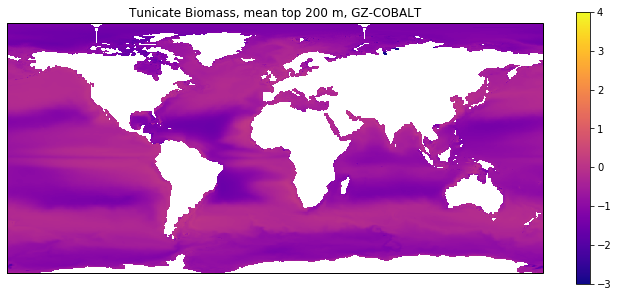

In [16]:
plt.figure(figsize=(12,5))
field=np.log10((ds.nsmt_100 + ds.nlgt_100).mean(dim='time') * carbon_molar_mass * 1000 / 100)
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='plasma', vmax=4, vmin=-3)
plt.colorbar(cs)
plt.title('Tunicate Biomass, mean top 200 m, GZ-COBALT')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_tunicates_biomass.png', dpi=150, bbox_inches='tight')

In [17]:
ds.nsmt_100

<xarray.DataArray 'nsmt_100' (time: 12, yh: 576, xh: 720)>
dask.array<concatenate, shape=(12, 576, 720), dtype=float32, chunksize=(1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time     (time) object 1999-07-18 00:00:00 ... 2000-06-17 00:00:00
Attributes:
    long_name:      Small tunicate nitrogen biomass in upper 100m
    units:          mol m-2
    cell_measures:  area: areacello
    cell_methods:   area:mean yh:mean xh:mean time: mean within months time: ...
    time_avg_info:  average_T1,average_T2,average_DT

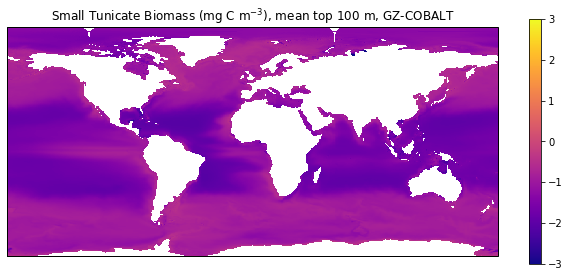

In [18]:
plt.figure(figsize=(11,4.5))
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

field=np.log10((ds.nsmt_100).mean(dim='time') * carbon_molar_mass * 1000 / 100) # mg C m-3

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmax=3,vmin=-3, cmap='plasma')
plt.colorbar(cs)
plt.title('Small Tunicate Biomass (mg C m$^{-3}$), mean top 100 m, GZ-COBALT')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_smtunicates_biomass.png', dpi=150, bbox_inches='tight')

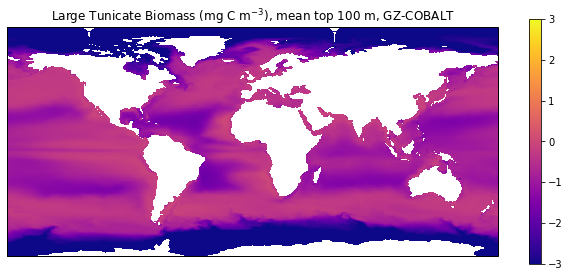

In [19]:
plt.figure(figsize=(11,4.5))
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

field=np.log10((ds.nlgt_100).mean(dim='time') * carbon_molar_mass * 1000 / 100)

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmax=3,vmin=-3, cmap='plasma')
plt.colorbar(cs)
plt.title('Large Tunicate Biomass (mg C m$^{-3}$), mean top 100 m, GZ-COBALT')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_lgtunicates_biomass.png', dpi=150, bbox_inches='tight')

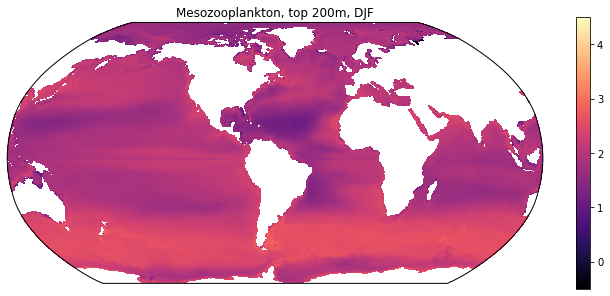

In [20]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

mz_djf = (ds.mesozoo_200.isel(time=11)/3 + ds.mesozoo_200.isel(time=0)/3 + ds.mesozoo_200.isel(time=1)/3)*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(mz_djf.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Mesozooplankton, top 200m, DJF')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_mesozoo_DJF.png', dpi=150, bbox_inches='tight')

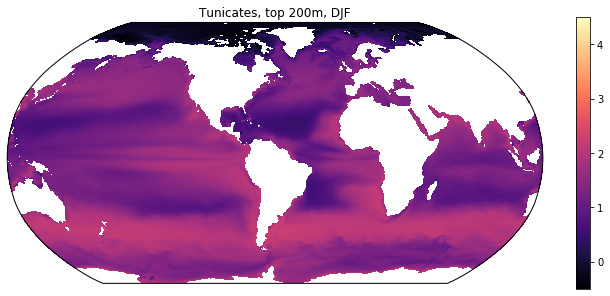

In [21]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

pt_djf = (ds.tunicate_200.isel(time=11)/3 + ds.tunicate_200.isel(time=0)/3 + ds.tunicate_200.isel(time=1)/3)*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(pt_djf.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Tunicates, top 200m, DJF')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_tunicates_DJF.png', dpi=150, bbox_inches='tight')

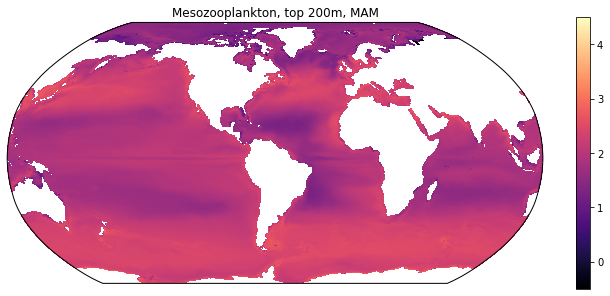

In [22]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

mz_mam = (ds.mesozoo_200.isel(time=slice(2,4)).mean(dim='time'))*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(mz_mam.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Mesozooplankton, top 200m, MAM')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_mesozoo_MAM.png', dpi=150, bbox_inches='tight')

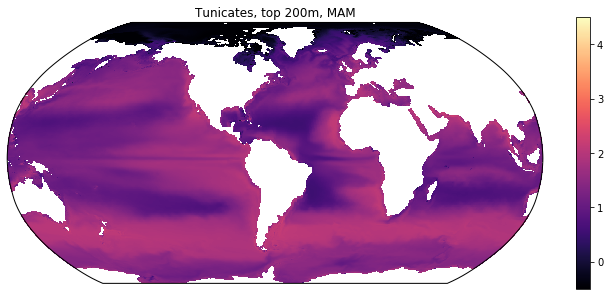

In [23]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

pt_mam = (ds.tunicate_200.isel(time=slice(2,4)).mean(dim='time'))*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(pt_mam.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Tunicates, top 200m, MAM')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_tunicates_MAM.png', dpi=150, bbox_inches='tight')

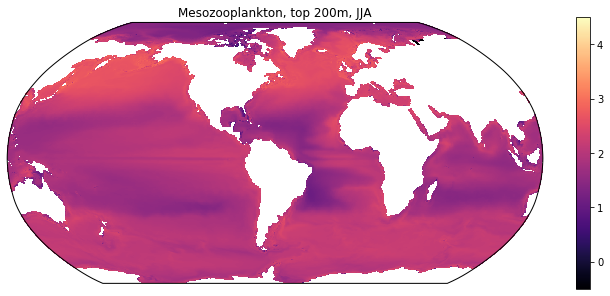

In [24]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

mz_jja = (ds.mesozoo_200.isel(time=slice(5,7)).mean(dim='time'))*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(mz_jja.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Mesozooplankton, top 200m, JJA')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_mesozoo_JJA.png', dpi=150, bbox_inches='tight')

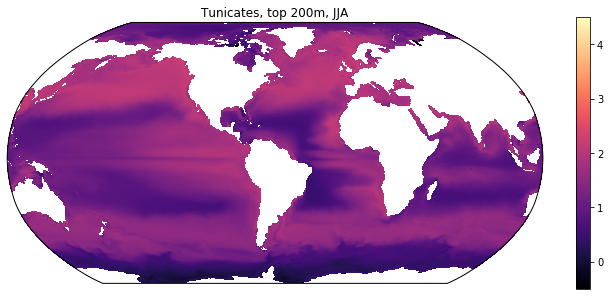

In [25]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

pt_jja = (ds.tunicate_200.isel(time=slice(5,7)).mean(dim='time'))*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(pt_jja.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Tunicates, top 200m, JJA')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_tunicates_JJA.png', dpi=150, bbox_inches='tight')

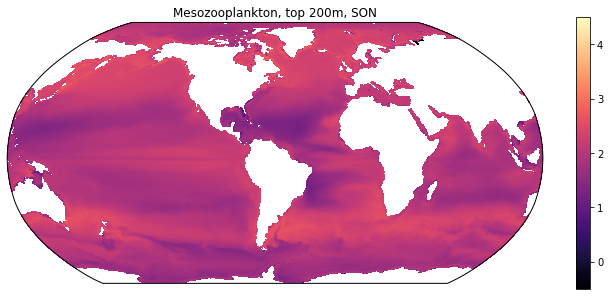

In [26]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

mz_son = (ds.mesozoo_200.isel(time=slice(8,10)).mean(dim='time'))*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(mz_son.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Mesozooplankton, top 200m, SON')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_mesozoo_SON.png', dpi=150, bbox_inches='tight')

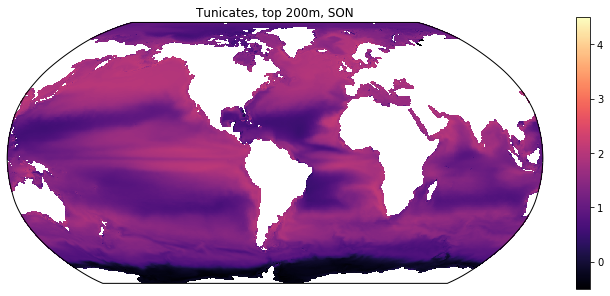

In [27]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))

pt_son = (ds.tunicate_200.isel(time=slice(8,10)).mean(dim='time'))*12.011*1000

cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, np.log10(pt_son.values), transform=ccrs.PlateCarree(), vmax=4.5, vmin=-0.5, cmap='magma')
plt.colorbar(cs)
plt.title('Tunicates, top 200m, SON')
plt.savefig('plots/'+short_casename+'_'+pp_dates+'_tunicates_SON.png', dpi=150, bbox_inches='tight')